In [210]:
import tensorflow as tf
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import time

In [215]:
def done():
    framerate = 44100
    duration=0.6
    freq=300
    t = np.linspace(0,duration,framerate*duration)
    data = np.sin(2*np.pi*freq*t)
    display(Audio(data, rate=framerate, autoplay=True))

In [2]:
X = pickle.load(open('../Data/X_train_triplet', 'rb'))
test = pickle.load(open('../Data/X_test_triplet', 'rb'))
y = pickle.load(open('../Data/y_test', 'rb'))

In [319]:
class siamese:

    # Create model
    def __init__(self, loss='cos', network='net'):
        tf.reset_default_graph()
        self.x1 = tf.placeholder(tf.float32, [None, 978])
        self.x2 = tf.placeholder(tf.float32, [None, 978])
        self.x3 = tf.placeholder(tf.float32, [None, 978])
        
        if network=='net':
            self.network = self.normalnet
        if network=='densenet':
            self.network = self.densenet

        with tf.variable_scope("siamese") as scope:
            self.o1 = self.network(self.x1)
            scope.reuse_variables()
            self.o2 = self.network(self.x2)
            scope.reuse_variables()
            self.o3 = self.network(self.x3)

        if loss=='cos':
            self.loss = self.loss_with_cosine()
        if loss=='euc':
            self.loss = self.loss_with_euclid()
            
    def normalnet(self, x):
        weights = []
        
        fc1 = self.fc_layer(x, 1024, "fc1")
        ac1 = tf.nn.relu(fc1)
        
        fc2 = self.fc_layer(ac1, 1024, "fc2")
        ac2 = tf.nn.relu(fc2)
        
#         fc3 = self.fc_layer(ac2, 1024, "fc3")
#         ac3 = tf.nn.relu(fc3)
        
        fc4 = self.fc_layer(ac2, 32, "fc4")
        
        fc4 = tf.nn.l2_normalize(fc4, axis=1)
        return fc4

    def dense_network(self, x):
        weights = []
        
        fc1 = self.fc_layer(x, 400, "fc1")
        ac1 = tf.nn.relu(fc1)
        op_concat1 = tf.concat([x, ac1], axis=1)
        
        fc2 = self.fc_layer(op_concat1, 400, "fc2")
        ac2 = tf.nn.relu(fc2)
        op_concat2 = tf.concat([op_concat1, ac2], axis=1)
        
        fc3 = self.fc_layer(op_concat2, 400, "fc3")
        ac3 = tf.nn.relu(fc3)
        op_concat3 = tf.concat([op_concat2, ac3], axis=1)
        
        fc4 = self.fc_layer(op_concat3, 32, "fc4")
        
        fc4 = tf.nn.l2_normalize(fc4, axis=1)
        return fc4

    def fc_layer(self, bottom, n_weight, name):
        assert len(bottom.get_shape()) == 2
        n_prev_weight = bottom.get_shape()[1]
        initer = tf.truncated_normal_initializer(stddev=0.01)
        W = tf.get_variable(name+'W', dtype=tf.float32, shape=[n_prev_weight, n_weight], initializer=initer)
        b = tf.get_variable(name+'b', dtype=tf.float32, initializer=tf.constant(0.01, shape=[n_weight], dtype=tf.float32))
        fc = tf.nn.bias_add(tf.matmul(bottom, W), b)
        return fc

    def loss_with_euclid(self):  
        eucd2 = tf.pow(tf.subtract(self.o1, self.o2), 2)
        eucd2 = tf.sqrt(tf.reduce_sum(eucd2, axis=1))
        eucd2_mean = tf.reduce_mean(eucd2, axis=0)
        
        eucd3 = tf.pow(tf.subtract(self.o1, self.o3), 2)
        eucd3 = tf.sqrt(tf.reduce_sum(eucd3, axis=1))
        eucd3_mean = tf.reduce_mean(eucd3, axis=0)
        
        return eucd2_mean, eucd3_mean, eucd2, eucd3
    
    def loss_with_cosine(self):  
        eucd2 = tf.multiply(self.o1, self.o2)
        eucd2 = 1-tf.pow(tf.reduce_sum(eucd2, axis=1), 2)
        eucd2_mean = tf.reduce_mean(eucd2, axis=0)
        
        eucd3 = tf.multiply(self.o1, self.o3)
        eucd3 = 1-tf.pow(tf.reduce_sum(eucd3, axis=1), 2)
        eucd3_mean = tf.reduce_mean(eucd3, axis=0)
        
        return eucd2_mean, eucd3_mean, eucd2, eucd3

In [320]:
def run_network(s, epochs):    
    optim_pos = tf.train.AdamOptimizer(0.005).minimize(s.loss[0])
    optim_neg = tf.train.AdamOptimizer(0.005).minimize(-s.loss[1])
    with tf.Session() as session:  
        tf.initialize_all_variables().run()
        print("Initialized")

        feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]}

        p_loss = []
        n_loss = []
        train_acc_l = []
        test_acc_l = []
        print("Epoch\t\t+ Dist\t- Dist\t\tTrain\tTest")
        for a in range(epochs):        
            p_loss.append([])
            n_loss.append([])
            for b in range(len(X[0])):
                sys.stdout.write('\rEpoch %d:\t%d/%d' % (a, b+1, len(X[0])))
                feed_dict = {s.x1:X[0][b:b+1], s.x2:X[1][b:b+1], s.x3:X[2][b:b+1]}
                _, _, l = session.run([optim_pos, optim_neg, s.loss], feed_dict=feed_dict)
                p_loss[-1].append(l[0])
                n_loss[-1].append(l[1])
            p_loss[-1] = sum(p_loss[-1])/len(p_loss[-1])
            n_loss[-1] = sum(n_loss[-1])/len(n_loss[-1]) 
            
            trained = session.run([s.loss], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
            pred = session.run([s.loss], feed_dict={s.x1:test[0], s.x2:test[1], s.x3:test[2]})
            
            train_acc = 100*(np.sum(trained[0][2]<=0.5)+np.sum(trained[0][3]>0.5))/len(X[0])/2
            test_acc = 100*(np.sum(pred[0][2]<=0.5)+np.sum(pred[0][3]>0.5))/len(X[0])/2 
            
            train_acc_l.append(train_acc)
            test_acc_l.append(test_acc)
            
#             print(" ", p_loss[-1], n_loss[-1], train_acc, test_acc)
            print(f"\rEpoch {a}:\t{'{0:.4f}'.format(p_loss[-1])}\t{'{0:.4f}'.format(n_loss[-1])}\t\t{'{0:.2f}'.format(train_acc)}\t{'{0:.2f}'.format(test_acc)}")

        embeddings = session.run([s.o1, s.o2, s.o3], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
        trained = session.run([s.loss], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
        pred = session.run([s.loss], feed_dict={s.x1:test[0], s.x2:test[1], s.x3:test[2]})
        
        return embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l

In [321]:
def graph(p_loss, n_loss, train_acc_l=None, test_acc_l=None):
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(epochs), p_loss, label='positive')
    plt.plot(np.arange(epochs), n_loss, label='negative')
    plt.legend()
    plt.title("Loss over epochs")
    plt.show()
    
    if train_acc_l!=None and test_acc_l!=None:
        plt.figure(figsize=(20, 6))
        plt.plot(np.arange(epochs), train_acc_l, label='train')
        plt.plot(np.arange(epochs), test_acc_l, label='test')
        plt.legend()
        plt.title("Accuracy over epochs")
        plt.show()

In [322]:
epochs = 4

### Euclidean

In [323]:
s = siamese("euc", "net")

In [314]:
embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l = run_network(s, epochs)

Initialized
Epoch		+ Dist	- Dist		Train	Test
Epoch 0:	0.2997	0.6121		62.74	58.93
Epoch 1:	0.5140	0.9648		64.29	55.00
Epoch 2:	0.4019	1.0454		74.52	60.00
Epoch 3:	0.4822	1.3128		80.83	63.45


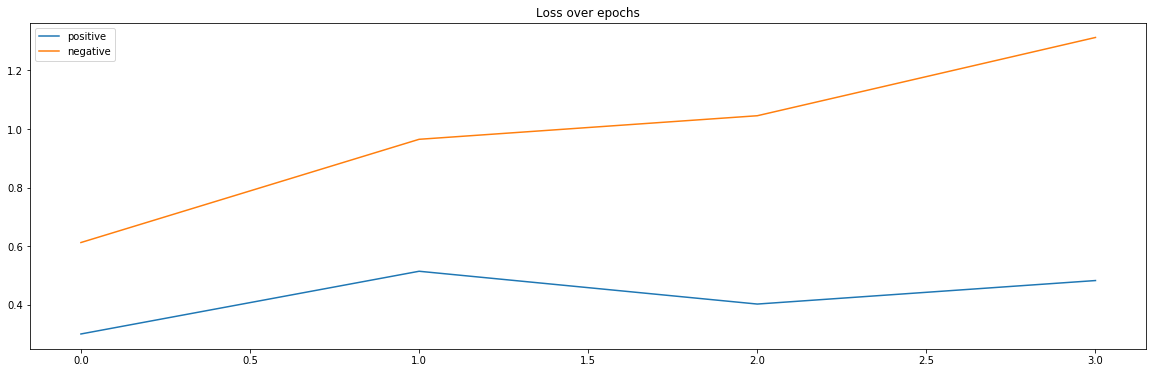

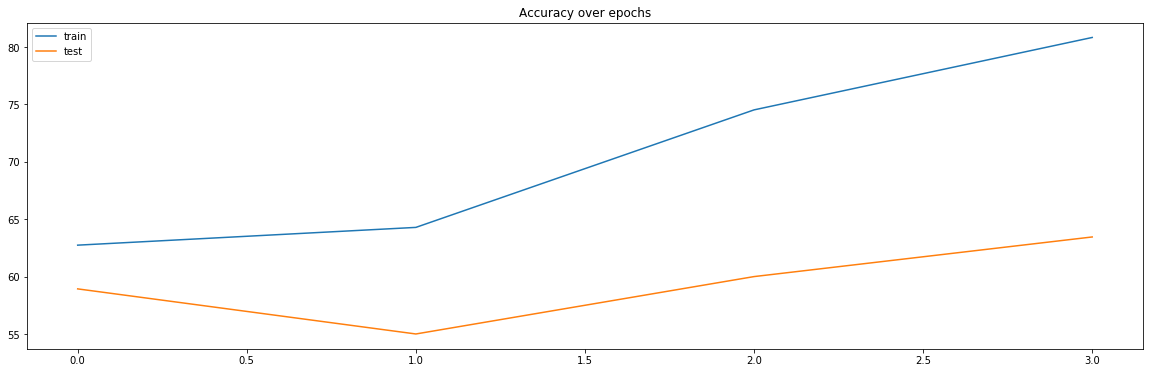

In [315]:
graph(p_loss, n_loss, train_acc_l, test_acc_l)

In [316]:
p = np.sum(trained[0][2]<=0.5)
n = np.sum(trained[0][3]>0.5)
print("Training Accuracy", (p+n)/420/2)

p = np.sum(pred[0][2]<=0.5)
n = np.sum(pred[0][3]>0.5)
print("Testing Accuracy", (p+n)/420/2)

Training Accuracy 0.8083333333333333
Testing Accuracy 0.6345238095238095


### Cosine

In [324]:
s = siamese("cos", "net")

In [325]:
embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l = run_network(s, epochs)

Initialized
Epoch		+ Dist	- Dist		Train	Test
Epoch 0:	0.2028	0.3693		62.02	54.29
Epoch 1:	0.2058	0.5318		70.83	56.31
Epoch 2:	0.1888	0.6233		79.17	55.36
Epoch 3:	0.1665	0.7291		81.55	56.43


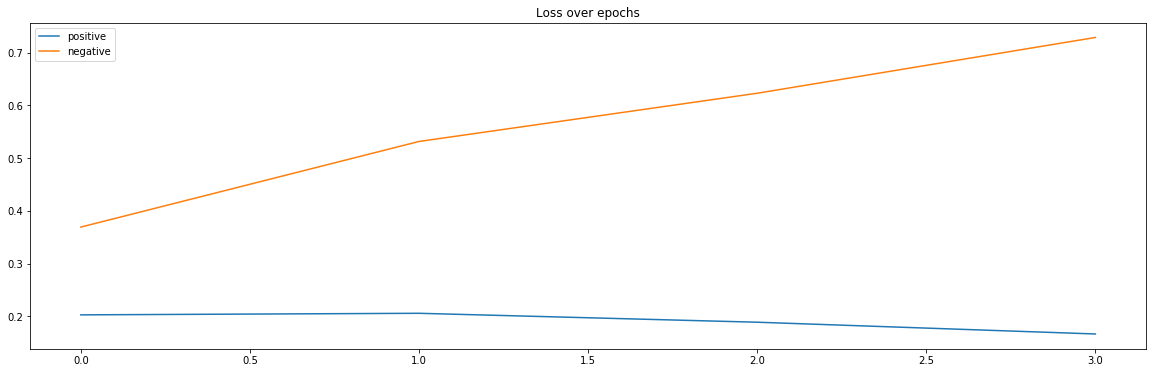

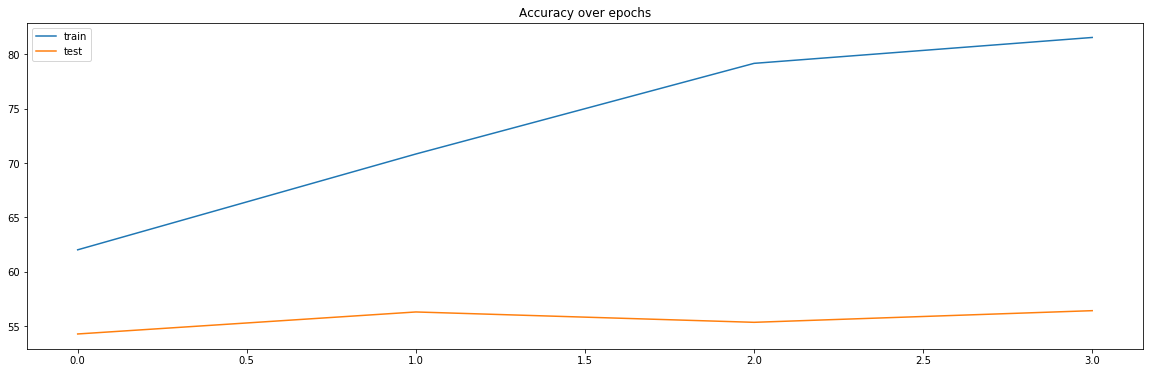

In [326]:
graph(p_loss, n_loss, train_acc_l, test_acc_l)

In [327]:
p = np.sum(trained[0][2]<=0.5)
n = np.sum(trained[0][3]>0.5)
print("Training Accuracy", (p+n)/420/2)

p = np.sum(pred[0][2]<=0.5)
n = np.sum(pred[0][3]>0.5)
print("Testing Accuracy", (p+n)/420/2)

Training Accuracy 0.8154761904761905
Testing Accuracy 0.5642857142857143


In [328]:
i = 3
while i:
    i-=1
    done()
    time.sleep(1.2)

/home/kavya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """
